<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Импорт библиотек

In [ ]:
# Для работы с данными
import numpy as np
import pandas as pd

# Для визуализации
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Для работы с текстом
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.probability import FreqDist
from nltk.corpus import wordnet, stopwords
from pymystem3 import Mystem

# Для моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# Метрика
from sklearn.metrics import r2_score

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
np.random.seed(59)

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Работа с данными

## Основные данные

Считаем данные

In [ ]:
df = pd.read_csv("./data/train/train_issues.csv")

Работа со временем

In [ ]:
df['created_time'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')
df['month'] = df['created_time'].dt.month
df['day'] = df['created_time'].dt.day
df['hour'] = df['created_time'].dt.hour
df['minute'] = df['created_time'].dt.minute

df.drop(['created', 'created_time'], axis=1, inplace=True)

Работа с ключем задачи

In [ ]:
df['key_name'] = df['key'].apply(lambda x: x.split('-')[0])
df['key_num'] = df['key'].apply(lambda x: x.split('-')[1]).astype('int64')

df.drop(['key'], axis=1, inplace=True)
df.head()

,id,summary,project_id,assignee_id,creator_id,overall_worklogs,month,day,hour,minute,key_name,key_num
0,819952,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,10,1,5,57,SM,10678
1,819949,"UI тесты раздела ""Профиль""",5,93,93,7200,10,1,5,59,SM,10679
2,819947,"UI тесты раздела ""Личный счет""",5,93,93,14400,10,1,6,0,SM,10680
3,819943,"UI тесты раздела ""Новости""",5,93,93,900,10,1,6,2,SM,10682
4,819941,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,10,1,6,3,SM,10683


Работа с описанием задачи

In [ ]:
m = Mystem()
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

Для того чтобы лемматизация работала, необходимо раскомментировать первые две строки при первом запуске

In [ ]:
# !wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
# !tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

cp: cannot create regular file '/root/.local/bin/mystem': Text file busy


In [ ]:
def clear_text(text):
    t = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\' ]', ' ', text)
    t = ' '.join(t.split())
    return t.lower()

def lemmatize_text_rus(text):
    tokens = m.lemmatize(text)
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    
    return text

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_with_pos_eng(text):
    pos_tagged = nltk.pos_tag(w_tokenizer.tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


df['clear_summary'] = df['summary'].apply(clear_text)
df['lemm_summary'] = df['clear_summary'].apply(lemmatize_text_rus)
df['lemm_summary'] = df['lemm_summary'].apply(lemmatize_with_pos_eng)

df.drop(['summary', 'clear_summary'], axis=1, inplace=True)

Эти стоп-слова пригодятся нам в дальнейшем при использовании tf-idf

In [ ]:
stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words('english')
stopwords_all = stopwords_rus + stopwords_eng

count_tf_idf = TfidfVectorizer(stop_words=stopwords_all)

Преобразуем таргет, чтобы исключить выбросы и минимизировать разброс

In [ ]:
df['log_target'] = np.log(df['overall_worklogs'])
df.drop(['overall_worklogs'], axis=1, inplace=True)

## Присоединяем дополнительные данные

### Информация о работниках

Считаем данные

In [ ]:
df_emp = pd.read_csv("./data/employees.csv")

Сразу отбросим бесполезное

In [ ]:
df_emp.drop(['english_level', 'salary_calculation_type', 'full_name'],
            axis=1, inplace=True)

In [ ]:
df_emp['payment_type'].fillna('unknown', inplace=True)
df_emp['hiring_type'].fillna('unknown', inplace=True)

In [ ]:
def position_cleaning(x):
    if x is np.NaN:
        return x
    
    x = x.lower().strip().replace('-', ' ')

    key_positions = ['web', 'директор', 'руководитель',
                     'devops', 'рекрутер', 'бухгалтер',
                     'hr', 'тестировщик']

    for key_pos in key_positions:
        if key_pos in x:
            x = key_pos
            break
    
    if x == 'рекрутер' or x == 'специалист отдела по управлению персоналом' or x == 'сорсер':
        return 'hr'
    elif x == 'графический дизайнер':
        return 'web'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(position_cleaning)
pos_pop = df_emp['position'].value_counts()

In [ ]:
def remark_pos(x):
    if x is np.NaN or pos_pop[x] < 3:
        return 'other'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(remark_pos)
df_emp.head()

,id,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,other,unknown,unknown,0,0,0,0,0
1,2,0,web,staff,fixed,0,0,0,0,0
2,4,0,web,staff,fixed,0,0,0,0,0
3,6,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
4,8,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1


Присоединяем информацию о работниках

In [ ]:
df = pd.merge(df, df_emp, left_on="assignee_id", right_on="id",
              how='left', suffixes=('', '_y'))

# df.drop(['creator_id', 'assignee_id', 'id_y'], axis=1, inplace=True)
df.drop(['id_y'], axis=1, inplace=True)

In [ ]:
df.head()

,id,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,...,log_target,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,819952,5,93,93,10,1,5,57,SM,10678,...,7.495542,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
1,819949,5,93,93,10,1,5,59,SM,10679,...,8.881836,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
2,819947,5,93,93,10,1,6,0,SM,10680,...,9.574983,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
3,819943,5,93,93,10,1,6,2,SM,10682,...,6.802395,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
4,819941,5,93,93,10,1,6,3,SM,10683,...,6.802395,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1


### Информация о комментариях

In [ ]:
df_coms = pd.read_csv("./data/train/train_comments.csv")

In [ ]:
df_coms_text = df_coms.groupby('issue_id')['text'].sum().reset_index()
df_coms_text.head()

,issue_id,text
0,669666,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...
1,669670,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...
2,670930,I encountered a problem with access to `/users...
3,670934,I have read the neo4j documentation and also I...
4,675979,Взял диск у Артура. Нашел в офисе комп собрал ...


In [ ]:
df_coms_text['text'] = df_coms_text['text'].apply(clear_text)
df_coms_text['text'] = df_coms_text['text'].apply(lemmatize_text_rus)
df_coms_text['text'] = df_coms_text['text'].apply(lemmatize_with_pos_eng)
df_coms_text.head()

,issue_id,text
0,669666,http www youtube com watch v tuhodtsvony http ...
1,669670,ok accountid f ab a df b e f thanka for the up...
2,670930,i encounter a problem with access to user id e...
3,670934,i have read the neo j documentation and also i...
4,675979,взять диск у артур находить в офис комп собира...


In [ ]:
df = pd.merge(df, df_coms_text, left_on="id", right_on="issue_id", how='left')
df['text'] = df['text'].fillna('')
df.drop(['issue_id'], axis=1, inplace=True)
df.head()

,id,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,...,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text
0,819952,5,93,93,10,1,5,57,SM,10678,...,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,
1,819949,5,93,93,10,1,5,59,SM,10679,...,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,приверять и принимать mr
2,819947,5,93,93,10,1,6,0,SM,10680,...,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,
3,819943,5,93,93,10,1,6,2,SM,10682,...,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,
4,819941,5,93,93,10,1,6,3,SM,10683,...,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,принимать mr


In [ ]:
df_coms_counts = df_coms.groupby('issue_id').agg({'comment_id': 'count',
                                                  'author_id': 'nunique'})
df_coms_counts.reset_index(inplace=True)
df_coms_counts.rename(columns={"comment_id":"comments_cnt",
                               "author_id":"authors_cnt"},
                      inplace=True)
df_coms_counts.head()

,issue_id,comments_cnt,authors_cnt
0,669666,1,1
1,669670,1,1
2,670930,3,1
3,670934,3,1
4,675979,5,1


In [ ]:
df = pd.merge(df, df_coms_counts, left_on="id", right_on="issue_id", how='left')
df.drop(['id', 'issue_id'], axis=1, inplace=True)

In [ ]:
df['comments_cnt'] = df['comments_cnt'].fillna(0).astype('int32')
df['authors_cnt'] = df['authors_cnt'].fillna(0).astype('int32')
df.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,93,93,10,1,5,57,SM,10678,ui тест по заказ добро кейджи,...,staff,fixed,1,1,1,1,1,,0,0
1,5,93,93,10,1,5,59,SM,10679,ui тест раздел профиль,...,staff,fixed,1,1,1,1,1,приверять и принимать mr,1,1
2,5,93,93,10,1,6,0,SM,10680,ui тест раздел личный счет,...,staff,fixed,1,1,1,1,1,,0,0
3,5,93,93,10,1,6,2,SM,10682,ui тест раздел новость,...,staff,fixed,1,1,1,1,1,,0,0
4,5,93,93,10,1,6,3,SM,10683,ui тест раздел зона скидка и доплата,...,staff,fixed,1,1,1,1,1,принимать mr,1,1


In [ ]:
df.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,93,93,10,1,5,57,SM,10678,ui тест по заказ добро кейджи,...,staff,fixed,1,1,1,1,1,,0,0
1,5,93,93,10,1,5,59,SM,10679,ui тест раздел профиль,...,staff,fixed,1,1,1,1,1,приверять и принимать mr,1,1
2,5,93,93,10,1,6,0,SM,10680,ui тест раздел личный счет,...,staff,fixed,1,1,1,1,1,,0,0
3,5,93,93,10,1,6,2,SM,10682,ui тест раздел новость,...,staff,fixed,1,1,1,1,1,,0,0
4,5,93,93,10,1,6,3,SM,10683,ui тест раздел зона скидка и доплата,...,staff,fixed,1,1,1,1,1,принимать mr,1,1


In [ ]:
df.to_csv('./data/prepared/train.csv', index=False)

In [ ]:
df.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,93,93,10,1,5,57,SM,10678,ui тест по заказ добро кейджи,...,staff,fixed,1,1,1,1,1,,0,0
1,5,93,93,10,1,5,59,SM,10679,ui тест раздел профиль,...,staff,fixed,1,1,1,1,1,приверять и принимать mr,1,1
2,5,93,93,10,1,6,0,SM,10680,ui тест раздел личный счет,...,staff,fixed,1,1,1,1,1,,0,0
3,5,93,93,10,1,6,2,SM,10682,ui тест раздел новость,...,staff,fixed,1,1,1,1,1,,0,0
4,5,93,93,10,1,6,3,SM,10683,ui тест раздел зона скидка и доплата,...,staff,fixed,1,1,1,1,1,принимать mr,1,1


## Разделение данных

In [ ]:
X = df.drop(['log_target'], axis=1)
# X = df.drop(['log_target', 'lemm_summary'], axis=1)
y = df[['log_target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=59)
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_train = y_train.values
y_val = y_val.values
X_train.shape, X_val.shape

((8150, 22), (1439, 22))

In [ ]:
X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,48,1,1,4,16,18,15,ADBKRK,746,please check contact,...,unknown,unknown,0,0,0,0,0,chittrapan this contact be checkout successful...,1,1
1,13,86,86,3,4,8,45,BALT,4424,add loader for dropdowns in ib curriculum wiza...,...,staff,fixed,1,1,1,1,1,,0,0
2,13,86,86,9,8,11,6,BALT,7867,refactore the code add improvement and fix bug,...,staff,fixed,1,1,1,1,1,,0,0
3,13,365,193,9,1,16,16,BALT,7725,text not align in preview mode on the canvas,...,staff,hourly,1,1,1,1,1,,0,0
4,13,365,365,10,14,12,38,BALT,8552,bug after close background selector on canvas,...,staff,hourly,1,1,1,1,1,,0,0


Применяем tf-idf к summary

In [ ]:
X_train_new = count_tf_idf.fit_transform(X_train['lemm_summary'])
feature_names_tf = list(map(lambda x: x + '_tf', count_tf_idf.get_feature_names_out()))

X_train_new_df = pd.DataFrame(X_train_new.toarray(), columns=feature_names_tf)
X_train.drop('lemm_summary', axis=1, inplace=True)
X_train = pd.concat([X_train, X_train_new_df], axis=1)

X_val_new = count_tf_idf.transform(X_val['lemm_summary'])
X_val_new_df = pd.DataFrame(X_val_new.toarray(), columns=feature_names_tf)
X_val.drop('lemm_summary', axis=1, inplace=True)
X_val = pd.concat([X_val, X_val_new_df], axis=1)

X_train.shape, X_val.shape

((8150, 4358), (1439, 4358))

Применяем tf-idf к комментариям

In [ ]:
comm_tf_idf = TfidfVectorizer(stop_words=stopwords_all, max_features=5000)

X_train_new = comm_tf_idf.fit_transform(X_train['text'])
feature_names_tf_comms = list(map(lambda x: x + '_tf_comm', comm_tf_idf.get_feature_names_out()))
X_train_new_df = pd.DataFrame(X_train_new.toarray(), columns=feature_names_tf_comms)
X_train.drop('text', axis=1, inplace=True)
X_train = pd.concat([X_train, X_train_new_df], axis=1)

X_val_new = comm_tf_idf.transform(X_val['text'])
X_val_new_df = pd.DataFrame(X_val_new.toarray(), columns=feature_names_tf_comms)
X_val.drop('text', axis=1, inplace=True)
X_val = pd.concat([X_val, X_val_new_df], axis=1)

X_train.shape, X_val.shape

((8150, 9357), (1439, 9357))

In [ ]:
X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,...,эссаймент_tf_comm,эссайментов_tf_comm,этап_tf_comm,это_tf_comm,юзаться_tf_comm,юзер_tf_comm,юнит_tf_comm,являться_tf_comm,язык_tf_comm,январь_tf_comm
0,48,1,1,4,16,18,15,ADBKRK,746,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,86,86,3,4,8,45,BALT,4424,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,86,86,9,8,11,6,BALT,7867,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,365,193,9,1,16,16,BALT,7725,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,365,365,10,14,12,38,BALT,8552,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Применяем Label Encoding (так как ключевыми моделями будут деревья и их производные, то выбор справедлив)

In [ ]:
cat_features = ['key_name', 'position',
                'hiring_type', 'payment_type']

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1)
X_train[cat_features] = ord_encoder.fit_transform(X_train[cat_features])
X_val[cat_features] = ord_encoder.transform(X_val[cat_features])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8150 entries, 0 to 8149
Columns: 9357 entries, project_id to январь_tf_comm
dtypes: float64(9341), int32(2), int64(14)
memory usage: 581.8 MB


# Работа с моделью

In [ ]:
model = XGBRegressor(max_depth=23, random_state=59)
model.fit(X_train, y_train)

[09:14:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=23, random_state=59)

In [ ]:
pred = model.predict(X_val)
score = r2_score(y_val, pred)
score

0.27006045333504747

## Анализ модели

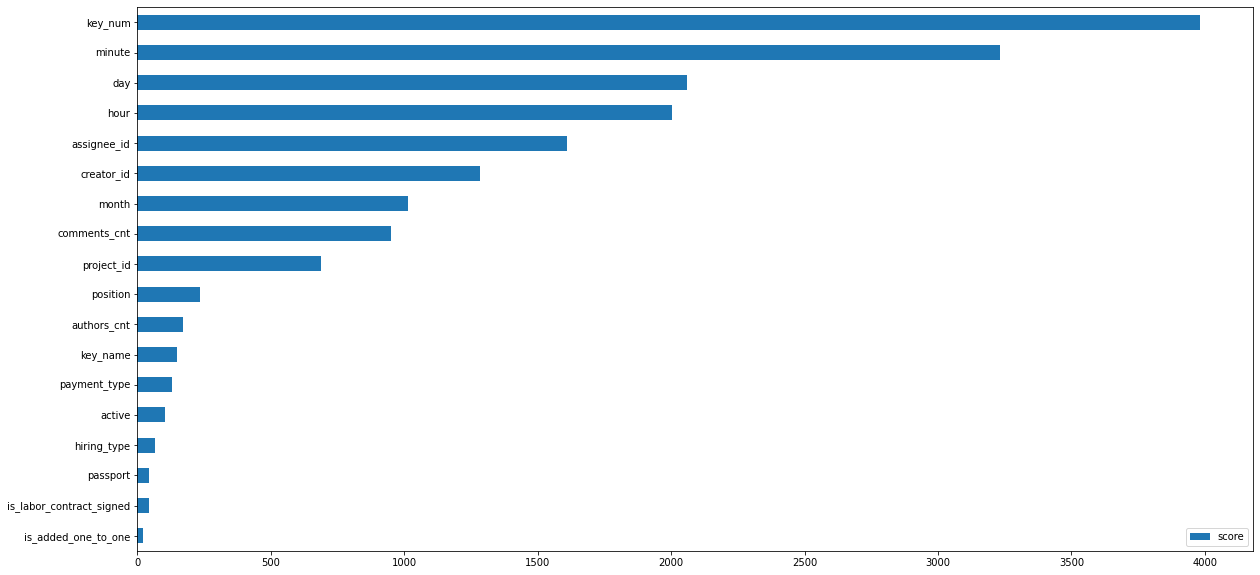

In [ ]:
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys,
                    columns=["score"]).sort_values(by="score", ascending=False)
data.nsmallest(40, columns="score").plot(kind='barh', figsize=(20, 10)) ## plot top 40 features

In [ ]:
data

,score
assignee_id,97
month,93
creator_id,87
comments_cnt,86
key_name,62
minute,57
hour,48
day,47
project_id,23
year,20


In [ ]:
feature_importance

{'key_name': 62,
 'assignee_id': 97,
 'comments_cnt': 86,
 'month': 93,
 'creator_id': 87,
 'authors_cnt': 17,
 'hour': 48,
 'active': 9,
 'payment_type': 19,
 'project_id': 23,
 'minute': 57,
 'is_labor_contract_signed': 5,
 'position': 12,
 'year': 20,
 'day': 47,
 'passport': 1}

# Сабмит на сайт

## Обработка тестовых данных

Считаем данные

In [ ]:
df_test = pd.read_csv("./data/test/test_issues.csv")

In [ ]:
df_test['created_time'] = pd.to_datetime(df_test['created'], format='%Y-%m-%d %H:%M:%S')
df_test['month'] = df_test['created_time'].dt.month
df_test['day'] = df_test['created_time'].dt.day
df_test['hour'] = df_test['created_time'].dt.hour
df_test['minute'] = df_test['created_time'].dt.minute

df_test['key_name'] = df_test['key'].apply(lambda x: x.split('-')[0])
df_test['key_num'] = df_test['key'].apply(lambda x: x.split('-')[1]).astype('int64')

df_test['clear_summary'] = df_test['summary'].apply(clear_text)
df_test['clear_summary'] = df_test['clear_summary'].str.lower()
df_test['lemm_summary'] = df_test['clear_summary'].apply(lemmatize_text_rus)
df_test['lemm_summary'] = df_test['lemm_summary'].apply(lemmatize_with_pos_eng)

df_test = pd.merge(df_test, df_emp, left_on="assignee_id", right_on="id",
                   how='left', suffixes=('', '_y'))

df_test.drop(['created', 'created_time'], axis=1, inplace=True)
# df_test.drop(['key', 'key_num'], axis=1, inplace=True)
df_test.drop(['key'], axis=1, inplace=True)
df_test.drop(['summary', 'clear_summary'], axis=1, inplace=True)
df_test.drop(['id_y'], axis=1, inplace=True)
# df_test.drop(['creator_id', 'assignee_id', 'id_y'], axis=1, inplace=True)
# df_test.drop(['lemm_summary', 'id_y'], axis=1, inplace=True)

df_test.head()

,id,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,675975,5,112,112,1,15,9,52,SM,11140,выгружать весь mp файл звонок на диск,0,devops,staff,fixed,0,0,0,0,0
1,675972,5,112,112,1,15,9,54,SM,11141,удалять файл mp звонок с сервер до,0,devops,staff,fixed,0,0,0,0,0
2,675965,5,94,54,1,16,4,46,SM,11144,удалять окно выбор тариф и перенести функциона...,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
3,675961,5,94,94,1,16,11,12,SM,11146,при авторизация пользователь водитель не видет...,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
4,675955,5,1,54,1,17,5,19,SM,11150,основной проблема по корп отдел по состояние н...,1,other,unknown,unknown,0,0,0,0,0


In [ ]:
df_coms_test = pd.read_csv('./data/test/test_comments.csv')

df_coms_text_test = df_coms_test.groupby('issue_id')['text'].sum().reset_index()
df_coms_text_test['text'] = df_coms_text_test['text'].apply(clear_text)
df_coms_text_test['text'] = df_coms_text_test['text'].apply(lemmatize_text_rus)
df_coms_text_test['text'] = df_coms_text_test['text'].apply(lemmatize_with_pos_eng)

df_test = pd.merge(df_test, df_coms_text_test, left_on="id", right_on="issue_id", how='left')
df_test['text'] = df_test['text'].fillna('')
df_test.drop(['issue_id'], axis=1, inplace=True)

df_coms_counts_test = df_coms_test.groupby('issue_id').agg({'comment_id': 'count',
                                                            'author_id': 'nunique'})
df_coms_counts_test.reset_index(inplace=True)
df_coms_counts_test.rename(columns={"comment_id":"comments_cnt",
                                    "author_id":"authors_cnt"},
                           inplace=True)
df_coms_counts_test.head()

,issue_id,comments_cnt,authors_cnt
0,670929,1,1
1,675825,1,1
2,675831,2,1
3,675834,1,1
4,675836,1,1


In [ ]:
df_test = pd.merge(df_test, df_coms_counts_test,
                   left_on="id", right_on="issue_id", how='left')
df_test.drop(['id', 'issue_id'], axis=1, inplace=True)
df_test['comments_cnt'] = df_test['comments_cnt'].fillna(0).astype('int32')
df_test['authors_cnt'] = df_test['authors_cnt'].fillna(0).astype('int32')
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,text,comments_cnt,authors_cnt
0,5,112,112,1,15,9,52,SM,11140,выгружать весь mp файл звонок на диск,...,staff,fixed,0,0,0,0,0,ресерч по rsync http losst ru rsync primery si...,8,1
1,5,112,112,1,15,9,54,SM,11141,удалять файл mp звонок с сервер до,...,staff,fixed,0,0,0,0,0,задача приостанавливать в связь с заморозка ра...,4,2
2,5,94,54,1,16,4,46,SM,11144,удалять окно выбор тариф и перенести функциона...,...,staff,fixed,0,0,0,0,0,задача закрывать в связь с передача проект,1,1
3,5,94,94,1,16,11,12,SM,11146,при авторизация пользователь водитель не видет...,...,staff,fixed,0,0,0,0,0,не правильно реализовать логика вызов метод ge...,2,2
4,5,1,54,1,17,5,19,SM,11150,основной проблема по корп отдел по состояние н...,...,unknown,unknown,0,0,0,0,0,ch keneskhanova прежде все по проблема коррект...,7,2


In [ ]:
df_test.to_csv('./data/prepared/test.csv', index=False)

In [ ]:
X_test_new = count_tf_idf.transform(df_test['lemm_summary'])
X_test_new_df = pd.DataFrame(X_test_new.toarray(), columns=feature_names_tf)
df_test.drop('lemm_summary', axis=1, inplace=True)
X_test = pd.concat([df_test, X_test_new_df], axis=1)

# X_test = df_test
X_test[cat_features] = ord_encoder.transform(X_test[cat_features])
X_test.shape

(1070, 4358)

In [ ]:
X_test_new = comm_tf_idf.transform(X_test['text'])
X_test_new_df = pd.DataFrame(X_test_new.toarray(), columns=feature_names_tf_comms)
X_test.drop('text', axis=1, inplace=True)
X_test = pd.concat([X_test, X_test_new_df], axis=1)

X_test.shape

(1070, 9357)

In [ ]:
pred_test = np.rint(np.exp(model.predict(X_test))).astype('int64')
pred_test

array([18788, 11126,  6053, ...,  4438,  4654, 14800])

### Создаем датафрейм с предсказанием

In [ ]:
df_sample = pd.read_csv('./data/sample_solution.csv')
len(pred_test), len(df_sample)

(1070, 1070)

In [ ]:
df_sample.overall_worklogs = pred_test
df_sample.to_csv('./solutions/d23_tfidf_comm_real.csv', index=False)

## Проверяем предсказание

In [ ]:
df_solution = pd.read_csv('./solutions/d21_general_5000&3000.csv')
df_solution.head()

,id,overall_worklogs
0,675975,32711
1,675972,10040
2,675965,7156
3,675961,7610
4,675955,11975


In [ ]:
df_solution.describe()

,id,overall_worklogs
count,1.070000e+03,1070.000000
mean,7.970476e+05,9703.969159
std,2.869125e+05,11226.074862
min,6.709290e+05,994.000000
25%,7.208912e+05,5383.000000
50%,7.213915e+05,7270.500000
75%,7.217428e+05,10967.750000
max,2.183553e+06,252394.000000


In [ ]:
df_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                1070 non-null   int64
 1   overall_worklogs  1070 non-null   int64
dtypes: int64(2)
memory usage: 16.8 KB


# Преобразования среднего

Преобразуем к тренировочному распределению

In [ ]:
df = pd.read_csv("./data/train/train_issues.csv")

orig_mean = int(df.overall_worklogs.mean())
sol_mean = int(df_solution.overall_worklogs.mean())
orig_mean, sol_mean

NameError: ignored

In [ ]:
def transform_dist(x):
    x = x + orig_mean - sol_mean
    return x

In [ ]:
df_solution['overall_worklogs'] = df_solution['overall_worklogs'].apply(transform_dist)
df_solution.head()

NameError: ignored

In [ ]:
df_solution.describe()

,id,overall_worklogs
count,1.070000e+03,1070.000000
mean,7.970476e+05,17243.969159
std,2.869125e+05,11226.074862
min,6.709290e+05,8534.000000
25%,7.208912e+05,12923.000000
50%,7.213915e+05,14810.500000
75%,7.217428e+05,18507.750000
max,2.183553e+06,259934.000000


In [ ]:
df_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                1070 non-null   int64
 1   overall_worklogs  1070 non-null   int64
dtypes: int64(2)
memory usage: 16.8 KB


In [ ]:
df_solution.to_csv('./solutions/d21_general_5000&3000_mean.csv', index=False)

Проверка предсказания

In [ ]:
df_solution = pd.read_csv('./solutions/d21_general_5000&3000_mean.csv')
df_solution.head()

,id,overall_worklogs
0,675975,40251
1,675972,17580
2,675965,14696
3,675961,15150
4,675955,19515
